# Rakamin x ID/X Partners VIX Final Task - Credit Risk Prediction

*This is the source code for final task of building an end-to-end solution for Credit Risk Prediction*<br>
Ini adalah source-code untuk tugas membangun solusi end-to-end untuk Credit Risk Prediction

## Overview
Diperlukan sebuah sistem yang mampu memprediksi credit risk, dataset yang digunakan dalam membangun sistem model adalah data pinjaman sebelumnya yang diterima atau ditolak dengan rentang tahun 2007 sampai tahun 2014.

**Business Metrics:** Loss, Net Profit Margin

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data Preparation
### 1) Load data from csv file

In [2]:
raw_loan_data = pd.read_csv("loan_data_2007_2014.csv", low_memory=False)

In [3]:
raw_loan_data.head()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
raw_loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 75 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   466285 non-null  int64  
 1   id                           466285 non-null  int64  
 2   member_id                    466285 non-null  int64  
 3   loan_amnt                    466285 non-null  int64  
 4   funded_amnt                  466285 non-null  int64  
 5   funded_amnt_inv              466285 non-null  float64
 6   term                         466285 non-null  object 
 7   int_rate                     466285 non-null  float64
 8   installment                  466285 non-null  float64
 9   grade                        466285 non-null  object 
 10  sub_grade                    466285 non-null  object 
 11  emp_title                    438697 non-null  object 
 12  emp_length                   445277 non-null  object 
 13 

### 2. Drop empty columns from dataset
Bila dalam satu kolom tidak ada value/datanya sama sekali, atau null/NaN, maka kolom tersebut dapat diabaikan

In [5]:
nnc_loan_data = raw_loan_data.dropna(axis=1, how="all")

In [6]:
nnc_loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 58 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   466285 non-null  int64  
 1   id                           466285 non-null  int64  
 2   member_id                    466285 non-null  int64  
 3   loan_amnt                    466285 non-null  int64  
 4   funded_amnt                  466285 non-null  int64  
 5   funded_amnt_inv              466285 non-null  float64
 6   term                         466285 non-null  object 
 7   int_rate                     466285 non-null  float64
 8   installment                  466285 non-null  float64
 9   grade                        466285 non-null  object 
 10  sub_grade                    466285 non-null  object 
 11  emp_title                    438697 non-null  object 
 12  emp_length                   445277 non-null  object 
 13 

### 3. Check Loan Status at "loan_status" column
Status pinjaman terakhir/saat ini pada kolom "loan_status" dipilih sebagai data target untuk prediksi sementara apakah pinjaman yang bersangkutan berisiko atau tidak

In [7]:
nnc_loan_data["loan_status"].value_counts()

Current                                                224226
Fully Paid                                             184739
Charged Off                                             42475
Late (31-120 days)                                       6900
In Grace Period                                          3146
Does not meet the credit policy. Status:Fully Paid       1988
Late (16-30 days)                                        1218
Default                                                   832
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

Karena target prediksi credit risk yang ditentukan hanya dua, yaitu "berisiko" (risky loans) dan "tidak berisiko" (good loans), maka perlu dipastikan nilai dari status akhir pinjaman (loan_status) tidak ambigu. Berdasarkan value yang ada, nilai "Current" dan "In Grace Period" adalah nilai ambigu, tidak menjelaskan apakah status pinjaman selesai/dibayar atau belum/dibebankan. Maka di sini, dikelompokkan nilai/value yang menunjukkan apakah pinjaman bisa dinilai berisiko (risky) atau tidak (good) sebagai berikut:

1) **Risky loans:** "Charged Off", "Late (days/periods)", "Does not meet the credit policy. Status:Charged Off", "Default"
2) **Good loans:** "Fully Paid", "Does not meet the credit policy. Status:Fully Paid"

In [8]:
ambiguous = ["Current", "In Grace Period"]
good_loan = ["Fully Paid", "Does not meet the credit policy. Status:Fully Paid"]

nnc_loan_data = nnc_loan_data[nnc_loan_data["loan_status"].isin(ambiguous) == False]

Pemeriksaan kolom "loan_status" untuk memastikan sudah bersih dari nilai/value ambigu

In [9]:
nnc_loan_data["loan_status"].value_counts()

Fully Paid                                             184739
Charged Off                                             42475
Late (31-120 days)                                       6900
Does not meet the credit policy. Status:Fully Paid       1988
Late (16-30 days)                                        1218
Default                                                   832
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

### 4. Visualization
Visualisasi data hasil pembersihan sementara, untuk mengetahui jumlah/banyaknya loan/pinjaman yang diperkirakan berisiko (risky) maupun tidak (good). Dibuat kolom sementara untuk nilai/value "good" atau "risky", dengan nama kolom "loan_risk_est"

In [10]:
nnc_loan_data["loan_risk_est"] = np.where(nnc_loan_data["loan_status"].isin(good_loan), "good", "risky")

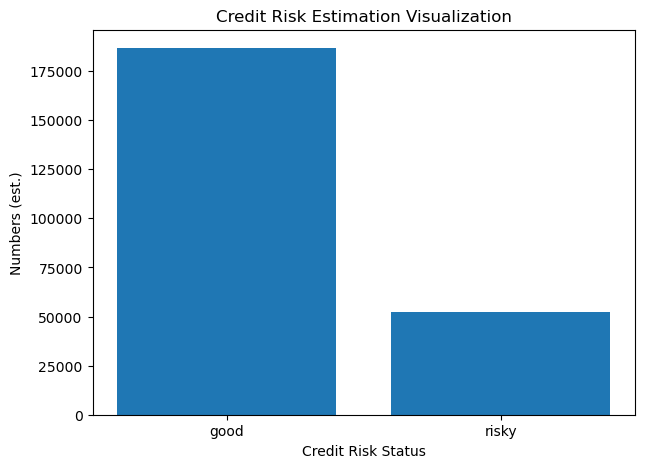

In [11]:
plt.figure(figsize=(7, 5))
plt.title("Credit Risk Estimation Visualization")
plt.bar(nnc_loan_data["loan_risk_est"].unique(),
        nnc_loan_data["loan_risk_est"].value_counts())
plt.xlabel("Credit Risk Status")
plt.ylabel("Numbers (est.)")
plt.show()

## Exploratory Data Analysis
### 1. Column Understanding

In [12]:
nnc_loan_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 238913 entries, 0 to 466283
Data columns (total 59 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   238913 non-null  int64  
 1   id                           238913 non-null  int64  
 2   member_id                    238913 non-null  int64  
 3   loan_amnt                    238913 non-null  int64  
 4   funded_amnt                  238913 non-null  int64  
 5   funded_amnt_inv              238913 non-null  float64
 6   term                         238913 non-null  object 
 7   int_rate                     238913 non-null  float64
 8   installment                  238913 non-null  float64
 9   grade                        238913 non-null  object 
 10  sub_grade                    238913 non-null  object 
 11  emp_title                    225435 non-null  object 
 12  emp_length                   229688 non-null  object 
 13 

Berdasarkan pemahaman terhadap kamus data yang tersedia/diberikan, kolom/field dari dataset dikelompokkan sebagai berikut:

*1) Field yang menjelaskan karakteristik pinjaman/loan*<br>
"id", "loan_amnt", "funded_amnt", "funded_amnt_inv", "term", "int_rate", "installment", "grade", "sub_grade", "application_type"

*2) Field yang menjelaskan identitas peminjam/borrower*<br>
"member_id", "emp_title", "emp_length", "home_ownership", "annual_inc", "verification_status", "zip_code", "addr_state", "dti"

*3) Field yang menjelaskan rekam jejak peminjam/borrower's personal records*<br>
"delinq_2yrs", "earliest_cr_line", "inq_last_6mths", "mths_since_last_delinq", "mths_since_last_record", "open_acc", "pub_rec", "revol_bal", "revol_util", "total_acc", "initial_list_status", "mths_since_last_major_derog", "acc_now_delinq"

*4) Field yang menjelaskan status akhir pinjaman yang berjalan/loan current status after issued*<br>
"issue_d", "loan_status", "pymnt_plan", "out_prncp", "out_prncp_inv", "total_pymnt", "total_pymnt_inv", "total_rec_prncp", "total_rec_int", "total_rec_late_fee", "recoveries", "collection_recovery_fee", "last_pymnt_d", "last_pymnt_amnt", "next_pymnt_d"

In [13]:
loan_chars = ["id",
               "loan_amnt",
               "funded_amnt", "funded_amnt_inv",
               "term",
               "int_rate",
               "installment",
               "grade", "sub_grade",
               "application_type"]

nnc_loan_data[loan_chars].head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,application_type
0,1077501,5000,5000,4975.0,36 months,10.65,162.87,B,B2,INDIVIDUAL
1,1077430,2500,2500,2500.0,60 months,15.27,59.83,C,C4,INDIVIDUAL
2,1077175,2400,2400,2400.0,36 months,15.96,84.33,C,C5,INDIVIDUAL
3,1076863,10000,10000,10000.0,36 months,13.49,339.31,C,C1,INDIVIDUAL
5,1075269,5000,5000,5000.0,36 months,7.90,156.46,A,A4,INDIVIDUAL


In [14]:
borrowers = ["member_id",
             "emp_title", "emp_length",
             "home_ownership",
             "annual_inc",
             "verification_status",
             "zip_code", "addr_state",
             "dti"]

nnc_loan_data[borrowers].head()

,member_id,emp_title,emp_length,home_ownership,annual_inc,verification_status,zip_code,addr_state,dti
0,1296599,NaN,10+ years,RENT,24000.0,Verified,860xx,AZ,27.65
1,1314167,Ryder,< 1 year,RENT,30000.0,Source Verified,309xx,GA,1.00
2,1313524,NaN,10+ years,RENT,12252.0,Not Verified,606xx,IL,8.72
3,1277178,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,917xx,CA,20.00
5,1311441,Veolia Transportaton,3 years,RENT,36000.0,Source Verified,852xx,AZ,11.20


In [15]:
borrower_trs = ["delinq_2yrs",
                "earliest_cr_line",
                "inq_last_6mths",
                "mths_since_last_delinq", "mths_since_last_record",
                "open_acc",
                "pub_rec",
                "revol_bal", "revol_util",
                "total_acc",
                "initial_list_status",
                "mths_since_last_major_derog",
                "acc_now_delinq"]

nnc_loan_data[borrower_trs].head()

,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,mths_since_last_major_derog,acc_now_delinq
0,0.0,Jan-85,1.0,NaN,NaN,3.0,0.0,13648,83.7,9.0,f,NaN,0.0
1,0.0,Apr-99,5.0,NaN,NaN,3.0,0.0,1687,9.4,4.0,f,NaN,0.0
2,0.0,Nov-01,2.0,NaN,NaN,2.0,0.0,2956,98.5,10.0,f,NaN,0.0
3,0.0,Feb-96,1.0,35.0,NaN,10.0,0.0,5598,21.0,37.0,f,NaN,0.0
5,0.0,Nov-04,3.0,NaN,NaN,9.0,0.0,7963,28.3,12.0,f,NaN,0.0


In [16]:
loan_stats = ["issue_d",
              "loan_status",
              "pymnt_plan",
              "out_prncp", "out_prncp_inv",
              "total_pymnt", "total_pymnt_inv",
              "total_rec_prncp", "total_rec_int", "total_rec_late_fee",
              "recoveries",
              "collection_recovery_fee",
              "last_pymnt_d", "last_pymnt_amnt",
              "next_pymnt_d"]

nnc_loan_data[loan_stats].head()

,issue_d,loan_status,pymnt_plan,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d
0,Dec-11,Fully Paid,n,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,Jan-15,171.62,NaN
1,Dec-11,Charged Off,n,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-13,119.66,NaN
2,Dec-11,Fully Paid,n,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,Jun-14,649.91,NaN
3,Dec-11,Fully Paid,n,0.0,0.0,12226.302210,12226.30,10000.00,2209.33,16.97,0.00,0.00,Jan-15,357.48,NaN
5,Dec-11,Fully Paid,n,0.0,0.0,5631.377753,5631.38,5000.00,631.38,0.00,0.00,0.00,Jan-15,161.03,NaN


### 2. Cleaning/Drop Unrequired Columns
Kolom/field yang menjelaskan status akhir pinjaman atau current loan status, seperti "issue_d", "loan_status", "pymnt_plan", dsb, hanya akan berisi data apabila pinjaman telah ditetapkan (issued). Hanya dengan satu atau sekumpulan kolom ini saja sudah dapat ditentukan mana pinjaman berisiko (risky loans) dan mana yang tidak (good loans), misalnya dari data/kolom "loan_status" sebagaimana yang telah ditunjukkan sebelumnya. Contoh lainnya adalah "out_prncp" (Outstanding Principal), jika bernilai 0 artinya pinjaman telah lunas (Fully Paid), ini sudah cukup menunjukkan bahwa pinjaman tidak berisiko. Kumpulan kolom/fiels ini menjadikan prediksi tidak diperlukan, sehingga kolom/fields ini akan dihapus dari dataset.

In [17]:
nnc_loan_data = nnc_loan_data.drop(columns=loan_stats, axis=1)

Kolom selanjutnya yang tidak diperlukan adalah "Unnamed: 0", "id", "member_id", "url", "desc", "zip_code", "title", dan "emp_title". "Unnamed: 0" hanya nomor index baris/record, "id" dan "member_id" adalah nomor identitas, "desc" hanya berisi keterangan/informasi tentang pinjaman yang bersangkutan, "zip_code" adalah kode pos alamat peminjam, "title" berisi judul pinjaman,"emp_title" berisi judul pekerjaan, kolom/fields ini tidak berpengaruh terhadap credit risk.

In [18]:
unused_cols = ["Unnamed: 0", "id", "member_id", "url", "desc", "zip_code", "title", "emp_title"]

nnc_loan_data = nnc_loan_data.drop(columns=unused_cols, axis=1)

Selanjutnya adalah memeriksa apakah ada kolom duplikasi, atau kumpulan kolom yang berisi nilai yang sama atau identik agar cukup digunakan salah satunya saja. Pemeriksaan dilakukan pada kolom-kolom numerik.

In [19]:
nnc_loan_data.select_dtypes(exclude="object")

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,...,revol_bal,revol_util,total_acc,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,5000,5000,4975.0,10.65,162.87,24000.0,27.65,0.0,1.0,NaN,...,13648,83.7,9.0,0.0,NaN,1,0.0,NaN,NaN,NaN
1,2500,2500,2500.0,15.27,59.83,30000.0,1.00,0.0,5.0,NaN,...,1687,9.4,4.0,0.0,NaN,1,0.0,NaN,NaN,NaN
2,2400,2400,2400.0,15.96,84.33,12252.0,8.72,0.0,2.0,NaN,...,2956,98.5,10.0,0.0,NaN,1,0.0,NaN,NaN,NaN
3,10000,10000,10000.0,13.49,339.31,49200.0,20.00,0.0,1.0,35.0,...,5598,21.0,37.0,0.0,NaN,1,0.0,NaN,NaN,NaN
5,5000,5000,5000.0,7.90,156.46,36000.0,11.20,0.0,3.0,NaN,...,7963,28.3,12.0,0.0,NaN,1,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466276,8525,8525,8525.0,18.25,217.65,37536.0,12.28,4.0,0.0,3.0,...,5318,10.7,26.0,0.0,4.0,1,0.0,0.0,116995.0,49800.0
466277,18000,18000,17975.0,7.90,563.23,90000.0,10.33,1.0,0.0,14.0,...,8224,16.3,33.0,0.0,14.0,1,0.0,0.0,42592.0,50300.0
466278,10000,10000,10000.0,18.25,362.78,42000.0,11.57,0.0,0.0,29.0,...,3196,28.8,24.0,0.0,32.0,1,0.0,0.0,10170.0,11100.0
466281,22000,22000,22000.0,19.97,582.50,78000.0,18.45,0.0,5.0,NaN,...,18238,46.3,30.0,0.0,NaN,1,0.0,0.0,221830.0,39400.0


Kolom "loan_amnt", "funded_amnt", "funded_amnt_inv" menunjukkan nilai-nilai yang hampir sama, cukup gunakan salah satu saja.<br>
Dalam notebook ini, kolom yang dipilih adalah "loan_amnt".

In [20]:
duplicate_cols = ["funded_amnt", "funded_amnt_inv"]

nnc_loan_data = nnc_loan_data.drop(columns=duplicate_cols, axis=1)

Selanjutnya, dilakukan pemeriksaan data lagi, karena data belum sepenuhnya bersih. Terdapat beberapa hal seperti nilai kosong (NaN), duplikasi, kesalahan format, dan juga outlier.

In [21]:
nnc_loan_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 238913 entries, 0 to 466283
Data columns (total 34 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   loan_amnt                    238913 non-null  int64  
 1   term                         238913 non-null  object 
 2   int_rate                     238913 non-null  float64
 3   installment                  238913 non-null  float64
 4   grade                        238913 non-null  object 
 5   sub_grade                    238913 non-null  object 
 6   emp_length                   229688 non-null  object 
 7   home_ownership               238913 non-null  object 
 8   annual_inc                   238909 non-null  float64
 9   verification_status          238913 non-null  object 
 10  purpose                      238913 non-null  object 
 11  addr_state                   238913 non-null  object 
 12  dti                          238913 non-null  float64
 13 

Bila diperhatikan, ada beberapa kolom yang memiliki banyak nilai kosong (NaN), misalnya kolom "mths_since_last_record" (Jumlah bulan sejak catatan publik terakhir), hanya 28949 baris saja yang berisi nilai dari total 238913 baris data. Selain itu, kolom "mths_since_last_major_derog" juga memiliki banyak nilai kosong, hanya 42544 baris saja yang berisi nilai, begitu juga dengan kolom-kolom lain yang banyaknya nilai terisi kurang dari 238913

Pada bagian ini, dilakukan peninjauan terhadap kolom "mths_since_last_delinq", "mths_since_last_record", dan "mths_since_last_major_derog" karena ketiga kolom ini memiliki nilai kosong terbanyak diantara semua kolom yang ada.

In [22]:
borrower_pr = ["mths_since_last_delinq", "mths_since_last_record", "mths_since_last_major_derog", "loan_risk_est"]

nnc_loan_data[borrower_pr]

,mths_since_last_delinq,mths_since_last_record,mths_since_last_major_derog,loan_risk_est
0,NaN,NaN,NaN,good
1,NaN,NaN,NaN,risky
2,NaN,NaN,NaN,good
3,35.0,NaN,NaN,good
5,NaN,NaN,NaN,good
...,...,...,...,...
466276,3.0,NaN,4.0,risky
466277,14.0,NaN,14.0,risky
466278,29.0,NaN,32.0,good
466281,NaN,116.0,NaN,risky


Bila diperhatikan lagi, sebagian besar record/data dengan ketiga kolom berisi nilai kosong diperkirakan menunjukkan credit risk yang rendah (good). Ditunjukkan pula bahwa semakin kecil nilai/angka, atau jumlah bulan sejak kesalahan atau catatan publik, maka semakin menunjukkan credit risk tinggi (risky).

Meninjau kembali kamus data, diketahui bahwa kolom "mths_since_last_delinq" berhubungan (related) dengan kolom "delinq_2yrs" dan "acc_now_delinq", dan kolom "mths_since_last_record" berhubungan dengan kolom "pub_rec", sehingga kolom "mths_since_last_delinq" dan "mths_since_last_record" dapat diabaikan dan dihapus (drop). Adapun untuk kolom "mths_since_last_major_derog" dapat diganti dengan kolom baru "major_derogatory" dengan nilai berisi 0 jika nilai "mths_since_last_major_derog" kosong, dan 1 jika berisi nilai.

In [23]:
unused_cols = ["mths_since_last_delinq", "mths_since_last_record", "mths_since_last_major_derog"]

nnc_loan_data["major_derogatory"] = np.where(nnc_loan_data["mths_since_last_major_derog"].isna(), 0, 1)
nnc_loan_data["major_derogatory"] = nnc_loan_data["major_derogatory"].astype("int64")
nnc_loan_data = nnc_loan_data.drop(unused_cols, axis=1)

Selanjutnya fokus pada kolom "tot_coll_amt", "tot_cur_bal", dan "total_rev_hi_lim". Ketiganya memiliki jumlah nilai kosong yang sama, tetapi perlu dilakukan pemeriksaan terlebih dahulu, sebab deskripsi ketiga kolom pada kamus data agak membingungkan

In [24]:
pivot_cols = ["tot_coll_amt", "tot_cur_bal", "total_rev_hi_lim"]

pd.pivot_table(nnc_loan_data, index="loan_risk_est", values=pivot_cols)

,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
loan_risk_est,,,
good,219.721618,143006.253262,29996.098672
risky,141.355723,116108.175291,26256.733754


In [25]:
pd.pivot_table(nnc_loan_data, index="loan_risk_est", values=pivot_cols, aggfunc=np.max)

,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
loan_risk_est,,,
good,9152545.0,8000078.0,2013133.0
risky,95806.0,3437283.0,1998700.0


Berdasarkan tabel pivot dengan nilai max, kolom "tot_coll_amt" terlihat mencurigakan.

In [26]:
nnc_loan_data[pivot_cols].describe()

,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
count,1.722900e+05,1.722900e+05,1.722900e+05
mean,2.009637e+02,1.365678e+05,2.910103e+04
std,2.211009e+04,1.501802e+05,2.854495e+04
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,2.795400e+04,1.320000e+04
50%,0.000000e+00,7.923900e+04,2.200000e+04
75%,0.000000e+00,2.064025e+05,3.620000e+04
max,9.152545e+06,8.000078e+06,2.013133e+06


<Axes: xlabel='tot_coll_amt', ylabel='Density'>

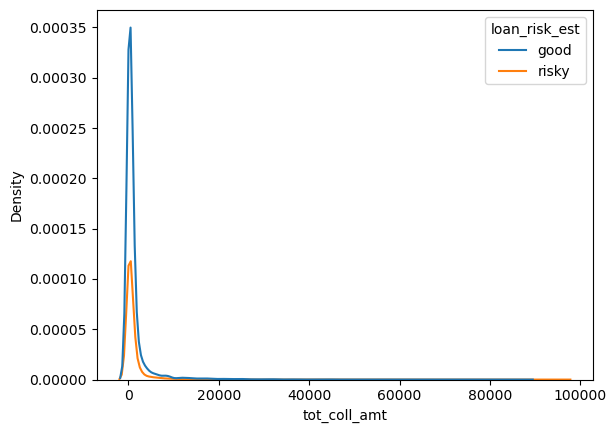

In [27]:
sns.kdeplot(nnc_loan_data[(nnc_loan_data["tot_coll_amt"] < 100000)
                          & nnc_loan_data["tot_coll_amt"] > 0],
            x="tot_coll_amt",
            hue="loan_risk_est")

<Axes: xlabel='tot_cur_bal', ylabel='Density'>

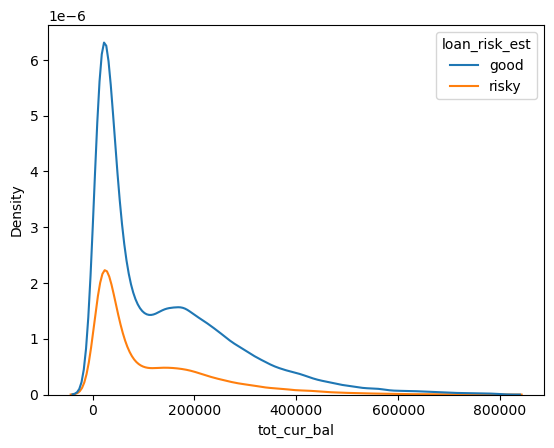

In [28]:
sns.kdeplot(nnc_loan_data[nnc_loan_data["tot_cur_bal"] < 800000],
            x="tot_cur_bal",
            hue="loan_risk_est")

<Axes: xlabel='total_rev_hi_lim', ylabel='Density'>

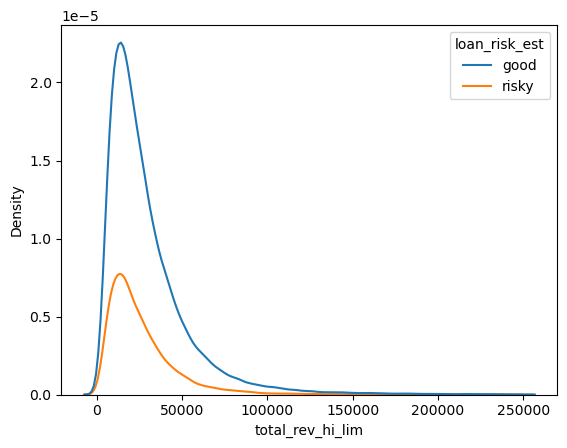

In [29]:
sns.kdeplot(nnc_loan_data[nnc_loan_data["total_rev_hi_lim"] < 250000],
            x="total_rev_hi_lim",
            hue="loan_risk_est")

Berdasarkan peninjauan dan visualisasi distribusi data kolom "tot_coll_amt", "tot_cur_bal", dan "total_rev_hi_lim", diperoleh kesimpulan berikut:
* Deskripsi kolom pada kamus data kurang jelas
* Sekitar 75% data "tot_coll_amt" bernilai 0
* Hasil visualisasi distribusi data ketiga kolom tidak menunjukkan pemisahan yang jelas antara pinjaman bagus (good) dengan pinjaman berisiko (risky)
* Bila ketiga kolom tetap atau dipaksakan digunakan dalam analisis data, maka harus menghilangkan lebih dari 50% baris/record

Untuk meminimalkan kekurangan data dan kesalahan dalam pengembangan model, maka ketiga kolom ini diabaikan/dihapus

In [30]:
unused_cols = ["tot_coll_amt", "tot_cur_bal", "total_rev_hi_lim"]

nnc_loan_data = nnc_loan_data.drop(unused_cols, axis=1)

Selanjutnya, dilakukan pemeriksaan untuk mengetahui keragaman nilai data (unique value) pada dataset, untuk mengetahui apakah nilai-nilai data yang berbeda menentukan berisiko atau tidaknya pinjaman

In [31]:
nnc_loan_data.nunique()[nnc_loan_data.nunique() < 10].sort_values()

policy_code                   1
application_type              1
term                          2
initial_list_status           2
loan_risk_est                 2
major_derogatory              2
verification_status           3
home_ownership                6
acc_now_delinq                6
grade                         7
collections_12_mths_ex_med    7
dtype: int64

Untuk kolom "policy_code" dan "application_type" hanya memiliki nilai seragam, sehingga dapat diabaikan/dihapus

In [32]:
unused_cols = ["policy_code", "application_type"]

nnc_loan_data = nnc_loan_data.drop(unused_cols, axis=1)

### 3. Categorizing and Imputation
Selanjutnya dilakukan visualisasi terhadap kolom-kolom dengan keragaman nilai kecil tersebut, untuk mengetahui hubungan antara nilai kolom dengan berisiko atau tidaknya pinjaman (good/risky)

In [33]:
def field_risk_vis(field):
    ratio = (nnc_loan_data.groupby(field)["loan_risk_est"]
             .value_counts(normalize=True)
             .mul(100)
             .rename("Risky Percentage")
             .reset_index())
    
    sns.lineplot(ratio[ratio["loan_risk_est"] == "risky"],
                 x=field, y="Risky Percentage")
    
    plt.title(field)
    plt.show()

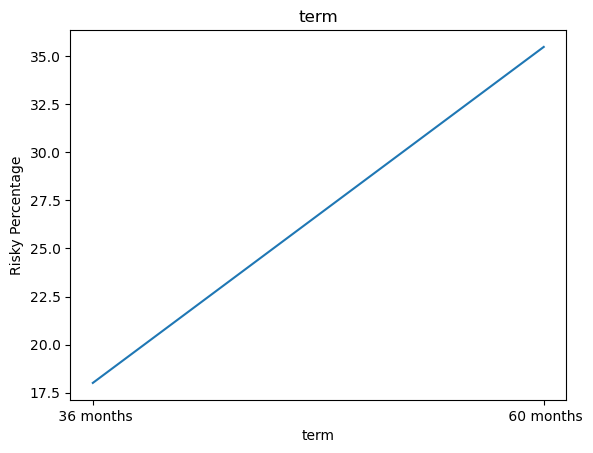

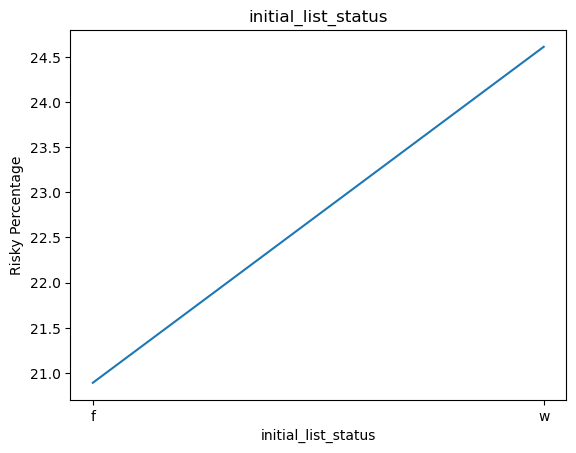

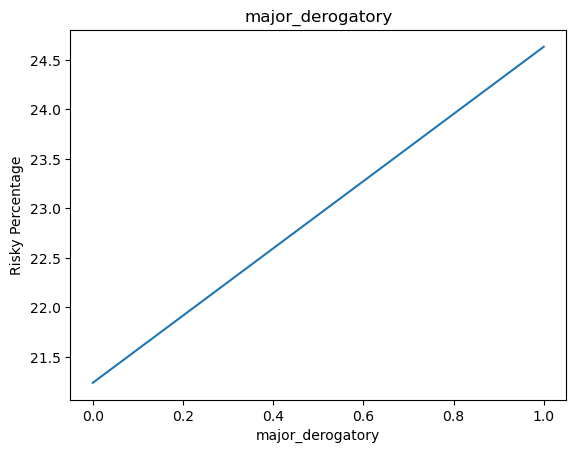

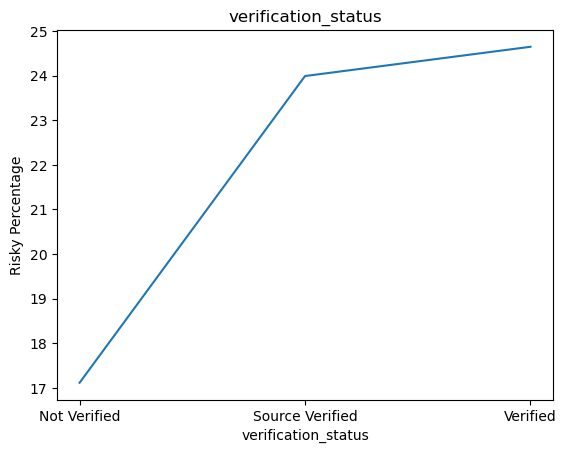

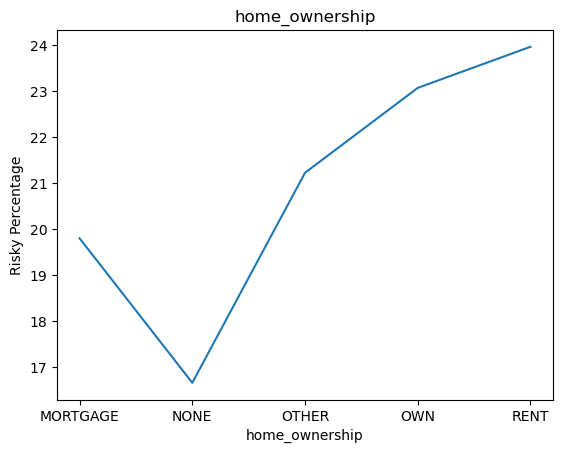

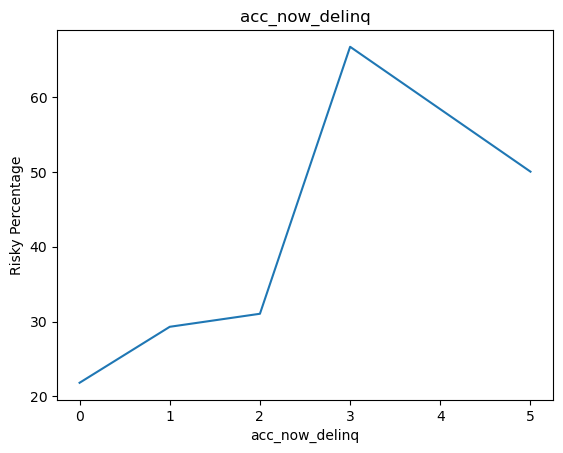

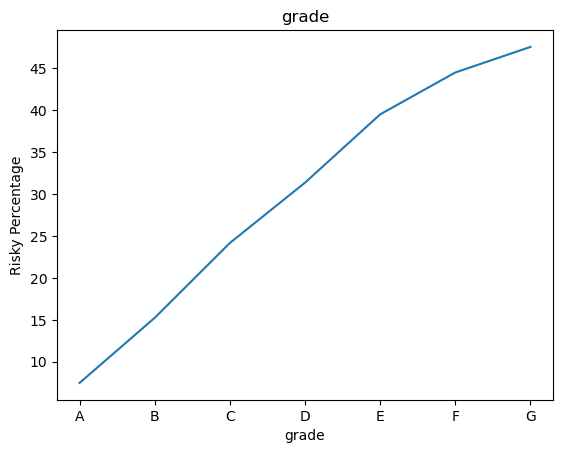

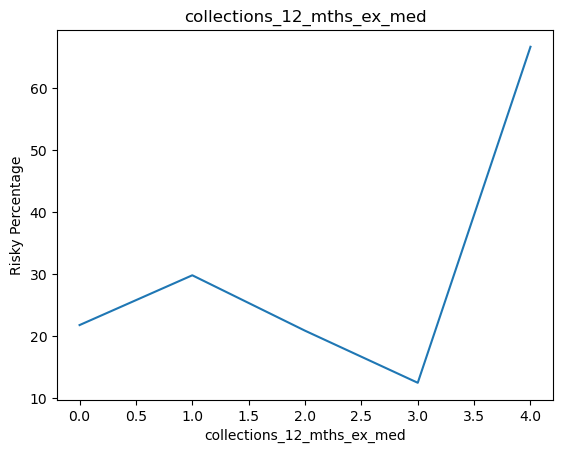

In [34]:
fields = nnc_loan_data.nunique()[nnc_loan_data.nunique() < 10].sort_values().index
fields = fields.drop("loan_risk_est")

for field in fields:
    field_risk_vis(field)

Berdasarkan visualisasi di atas, diketahui beberapa kolom memiliki nilai-nilai yang sangat memengaruhi berisiko tidaknya pinjaman, dan sebagian lagi tidak terlalu berpengaruh.

* Kolom dengan pengaruh besar meliputi "grade", "term", dan "acc_now_delinq"
* Kolom dengan pengaruh kecil meliputi "initial_list_status", "major_derogatory", "home_ownership", dan "verification_status"

Selanjutnya, dilakukan pengelompokan antara data kategorikal dan data numerik, lalu dilanjutkan pembersihan data

In [35]:
# Numeric
num_loan_data = nnc_loan_data.select_dtypes(exclude="object")
num_loan_data.head()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,collections_12_mths_ex_med,acc_now_delinq,major_derogatory
0,5000,10.65,162.87,24000.0,27.65,0.0,1.0,3.0,0.0,13648,83.7,9.0,0.0,0.0,0
1,2500,15.27,59.83,30000.0,1.00,0.0,5.0,3.0,0.0,1687,9.4,4.0,0.0,0.0,0
2,2400,15.96,84.33,12252.0,8.72,0.0,2.0,2.0,0.0,2956,98.5,10.0,0.0,0.0,0
3,10000,13.49,339.31,49200.0,20.00,0.0,1.0,10.0,0.0,5598,21.0,37.0,0.0,0.0,0
5,5000,7.90,156.46,36000.0,11.20,0.0,3.0,9.0,0.0,7963,28.3,12.0,0.0,0.0,0


In [36]:
# Categorical
cat_loan_data = nnc_loan_data.select_dtypes(include="object")
cat_loan_data

,term,grade,sub_grade,emp_length,home_ownership,verification_status,purpose,addr_state,earliest_cr_line,initial_list_status,last_credit_pull_d,loan_risk_est
0,36 months,B,B2,10+ years,RENT,Verified,credit_card,AZ,Jan-85,f,Jan-16,good
1,60 months,C,C4,< 1 year,RENT,Source Verified,car,GA,Apr-99,f,Sep-13,risky
2,36 months,C,C5,10+ years,RENT,Not Verified,small_business,IL,Nov-01,f,Jan-16,good
3,36 months,C,C1,10+ years,RENT,Source Verified,other,CA,Feb-96,f,Jan-15,good
5,36 months,A,A4,3 years,RENT,Source Verified,wedding,AZ,Nov-04,f,Sep-15,good
...,...,...,...,...,...,...,...,...,...,...,...,...
466276,60 months,D,D3,5 years,MORTGAGE,Verified,medical,MA,Nov-94,f,Oct-14,risky
466277,36 months,A,A4,3 years,RENT,Verified,debt_consolidation,MD,Jul-98,f,Oct-14,risky
466278,36 months,D,D3,10+ years,RENT,Source Verified,vacation,VA,Jun-02,f,Jan-16,good
466281,60 months,D,D5,10+ years,MORTGAGE,Verified,debt_consolidation,TN,Jun-97,f,Jan-16,risky


Bila diperhatikan baik-baik pada bagian kolom-kolom kategorikal, kolom "emp_length" seharusnya bertipe numerik, kolom "earliest_cr_line" dan "last_credit_pull_d" seharusnya bertipe datetime.

Bila membandingkan ketiga kolom dengan nilai good/risky pada kolom "loan_rsik_est", serta merujuk pada kamus data, maka diasumsikan:
* Lama pekerjaan (kolom "emp_length") bernilai antara 0 sampai 10 tahun, dimana 0 artinya kurang dari setahun dan 10 artinya 10 tahun atau lebih. Semakin besar nilai (0 ke 10) pada kolom, maka semakin kecil risiko pinjaman (ditunjukkan dengan nilai "good" pada kolom "loan_risk_est")
* Bulan jalur kredit paling awal (kolom "earliest_cr_line"), semakin lama/kebelakang tahun umumnya semakin baik rekam jejaknya
* Kolom "last_credit_pull_d" atau penarikan kredit terakhir, semakin lama jeda waktu antara pertanyaan (inquiry) dengan waktu terakhir (today) maka semakin baik

Akan tetapi, perlu dipastikan dulu apakah asumsi tersebut sudah benar. Untuk memudahkan, dilakukan pengkodean nilai kategorikal menjadi nilai numerik.

In [37]:
nnc_loan_data["emp_length"].unique()

array(['10+ years', '< 1 year', '3 years', '9 years', '4 years',
       '5 years', '1 year', '6 years', '2 years', '7 years', '8 years',
       nan], dtype=object)

In [38]:
emp_length = ["< 1 year", "1 years", "2 years", "3 years", "4 years",
              "5 years", "6 years", "7 years", "8 years", "9 years", "10+ years"]

emp_map = dict()
i = 0

for item in emp_length:
    emp_map[item] = i
    i = i + 1

emp_map

{'< 1 year': 0,
 '1 years': 1,
 '2 years': 2,
 '3 years': 3,
 '4 years': 4,
 '5 years': 5,
 '6 years': 6,
 '7 years': 7,
 '8 years': 8,
 '9 years': 9,
 '10+ years': 10}

In [39]:
nnc_loan_data["emp_length"] = cat_loan_data["emp_length"].map(emp_map).fillna("0").astype("int64")
nnc_loan_data[["emp_length", "loan_risk_est"]]

,emp_length,loan_risk_est
0,10,good
1,0,risky
2,10,good
3,10,good
5,3,good
...,...,...
466276,5,risky
466277,3,risky
466278,10,good
466281,10,risky


Berikut adalah transformasi data kolom "earliest_cr_line" dan "last_credit_pull_d" dari kategorikal menjadi datetime (numerik)

In [40]:
cat_loan_data["earliest_cr_year"] = pd.to_datetime(
    cat_loan_data["earliest_cr_line"],
    format="%b-%y"
).dt.year

nnc_loan_data["earliest_cr_line"] = np.where(
    cat_loan_data["earliest_cr_year"] > 2023,
    cat_loan_data["earliest_cr_year"] - 100,
    cat_loan_data["earliest_cr_year"]
)

nnc_loan_data["yr_since_last_inq"] = 2016 - pd.to_datetime(
    cat_loan_data["last_credit_pull_d"],
    format="%b-%y"
).dt.year

nnc_loan_data = nnc_loan_data.drop("last_credit_pull_d", axis=1)

nnc_loan_data[
    ["emp_length", "earliest_cr_line", "yr_since_last_inq"]
].describe()

,emp_length,earliest_cr_line,yr_since_last_inq
count,238913.000000,238884.000000,238890.000000
mean,5.499341,1997.493712,0.959149
std,3.806572,6.960065,1.162644
min,0.000000,1946.000000,0.000000
25%,2.000000,1994.000000,0.000000
50%,5.000000,1999.000000,1.000000
75%,10.000000,2002.000000,1.000000
max,10.000000,2011.000000,9.000000


Bila diperhatikan lagi, kolom "earliest_cr_line" dan "yr_since_last_inq" memiliki nilai kosong. Kolom "earliest_cr_line" hanya terisi 238884 nilai, dan kolom "yr_since_last_inq" hanya terisi 238890 dari total 238913.

Selanjutnya, dilakukan peninjauan lagi terhadap dataset untuk memastikan banyaknya nilai kosong pada masing-masing kolom. Disini dipisahkan antara kolom/data numerik dan kolom/data kategorikal

In [41]:
# Kolom numerik
num_loan_data = nnc_loan_data.select_dtypes(exclude="object")

num_loan_data.isna().sum()

loan_amnt                       0
int_rate                        0
installment                     0
emp_length                      0
annual_inc                      4
dti                             0
delinq_2yrs                    29
earliest_cr_line               29
inq_last_6mths                 29
open_acc                       29
pub_rec                        29
revol_bal                       0
revol_util                    232
total_acc                      29
collections_12_mths_ex_med    145
acc_now_delinq                 29
major_derogatory                0
yr_since_last_inq              23
dtype: int64

In [42]:
# Kolom kategorikal
cat_loan_data = nnc_loan_data.select_dtypes(include="object")

cat_loan_data.isna().sum()

term                   0
grade                  0
sub_grade              0
home_ownership         0
verification_status    0
purpose                0
addr_state             0
initial_list_status    0
loan_risk_est          0
dtype: int64

Terlihat bahwa sebagian kolom numerik memiliki nilai-nilai kosong, sementara kolom kategorikal semuanya terisi dan tidak ada nilai kosong. Karena nilai kosong bertipe numerik, maka dilakukan pengisian nilai kosong dengan imputasi multivariat menggunakan library "sklearn.impute.IterativeImputer"

In [43]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

nan_cols = ["annual_inc", "delinq_2yrs", "earliest_cr_line",
            "inq_last_6mths", "open_acc", "pub_rec", "revol_util",
            "total_acc", "collections_12_mths_ex_med",
            "acc_now_delinq", "yr_since_last_inq"]

imputer = IterativeImputer(max_iter=10, random_state=0)
num_loan_data[nan_cols] = imputer.fit_transform(num_loan_data[nan_cols])

In [44]:
num_loan_data.isna().sum()

loan_amnt                     0
int_rate                      0
installment                   0
emp_length                    0
annual_inc                    0
dti                           0
delinq_2yrs                   0
earliest_cr_line              0
inq_last_6mths                0
open_acc                      0
pub_rec                       0
revol_bal                     0
revol_util                    0
total_acc                     0
collections_12_mths_ex_med    0
acc_now_delinq                0
major_derogatory              0
yr_since_last_inq             0
dtype: int64

### 5. Visualization
Selanjutnya, kembali ke kolom "emp_length", "earliest_cr_line", dan "yr_since_last_inq" untuk dilakukan visualisasi, untuk mengetahui hubungan antara nilai kolom dengan berisiko atau tidaknya pinjaman (good/risky)

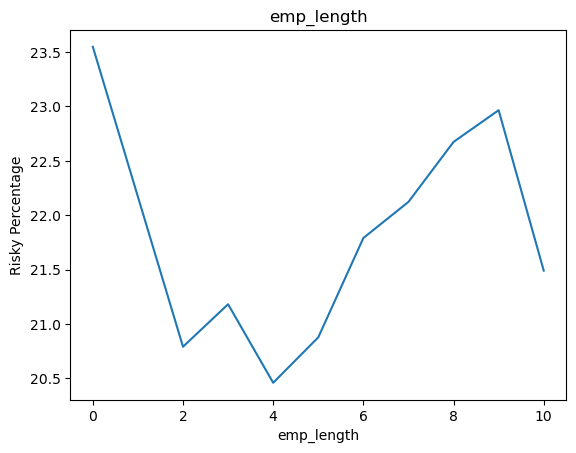

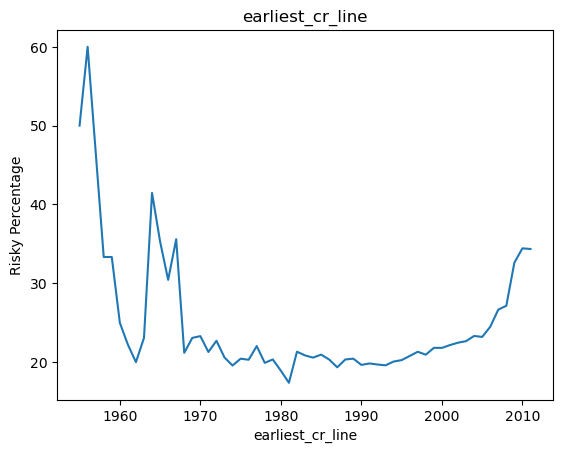

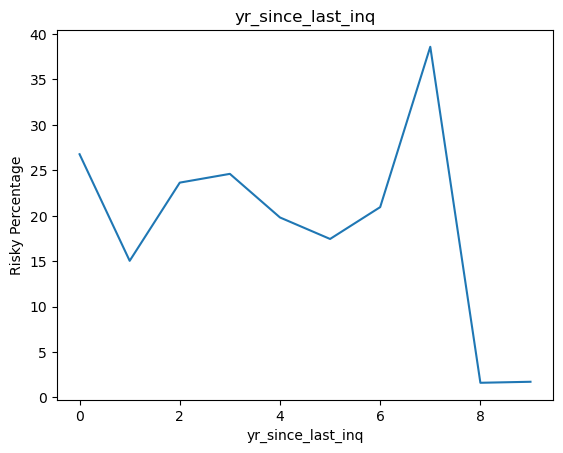

In [45]:
fields = ["emp_length", "earliest_cr_line", "yr_since_last_inq"]

for field in fields:
    field_risk_vis(field)

Berdasarkan visualisasi ketiga kolom tersebut, diperoleh kesimpulan sementara sebagai berikut:
* Lama pekerjaan ("emp_length") memiliki keragaman nilai, nilai kurang dari 1 tahun menunjukkan credit risk paling besar
* Bulan jalur kredit paling awal ("earliest_cr_line") sebelum 1960 menunjukkan credit risk paling besar
* Kolom "yr_since_last_inq" (Lama tahun sejak pertanyaan terakhir) menunjukkan credit risk paling besar antara nilai 6 dan 8

Selanjutnya, dilakukan visualisasi terhadap data numerik dan kategorikal untuk pemeriksaan berikut:

**1) Numerik**
* Histogram (distribusi data)
* Matriks Korelasi
* Pivot Table

**2) Kategorikal**
* Balance (keseimbangan data)
* Pivot Table

**Numerik:**

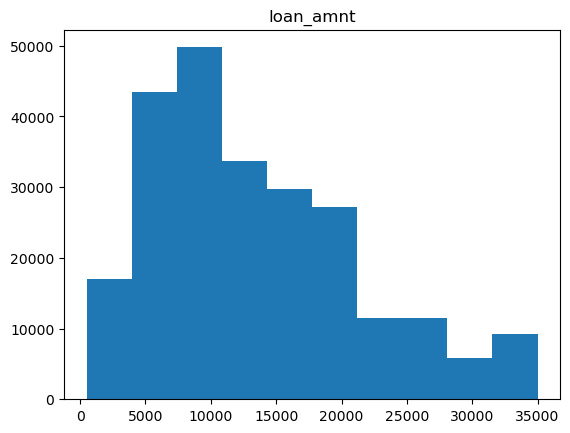

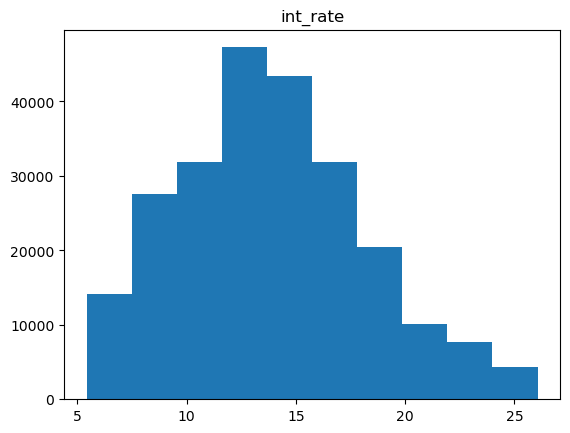

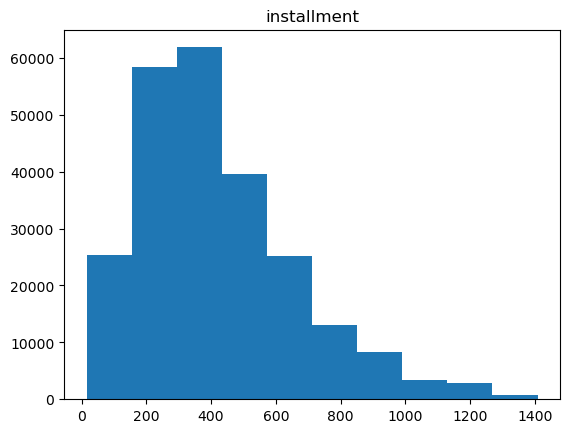

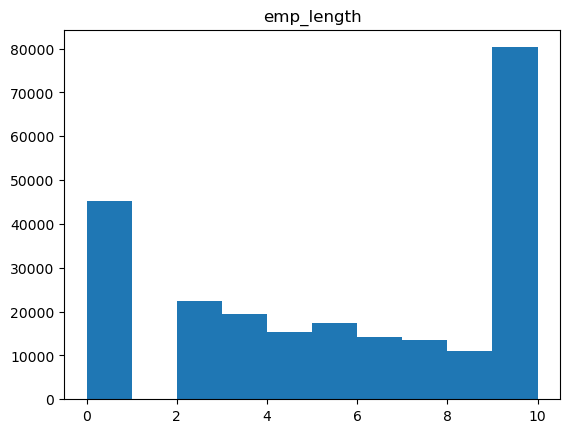

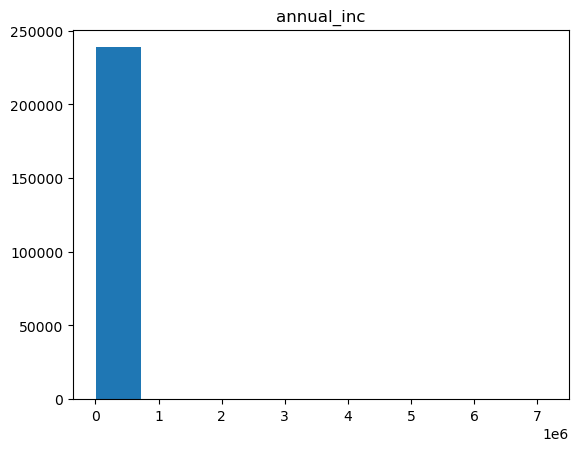

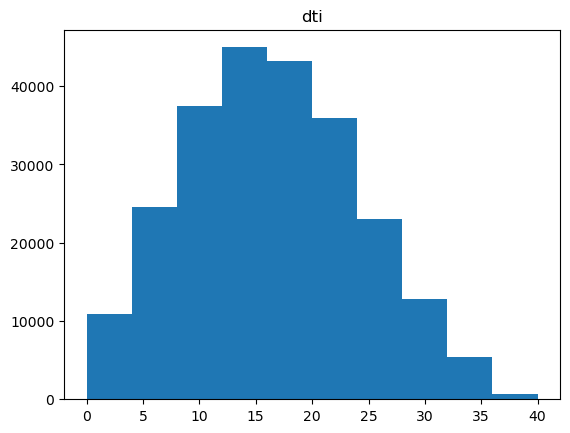

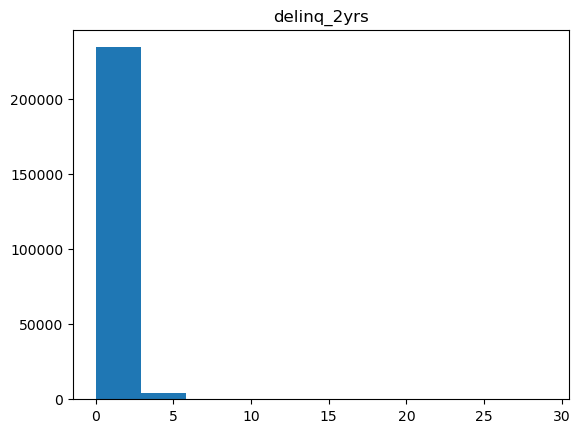

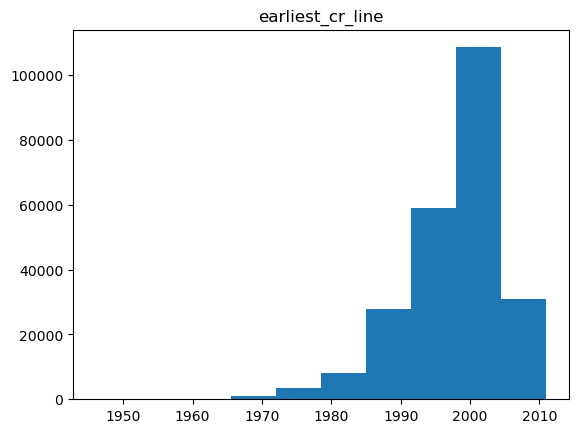

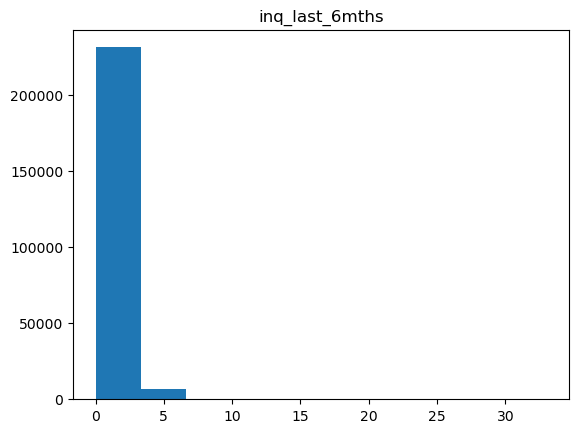

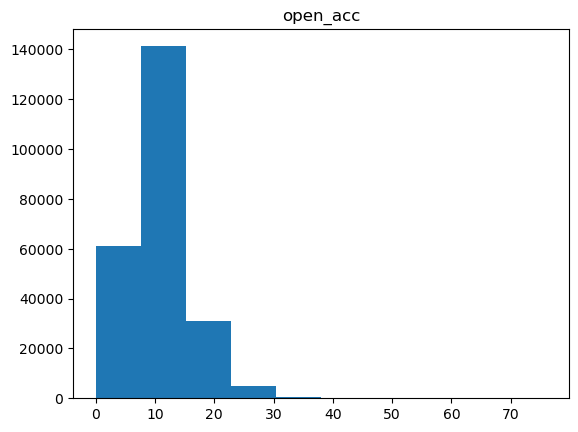

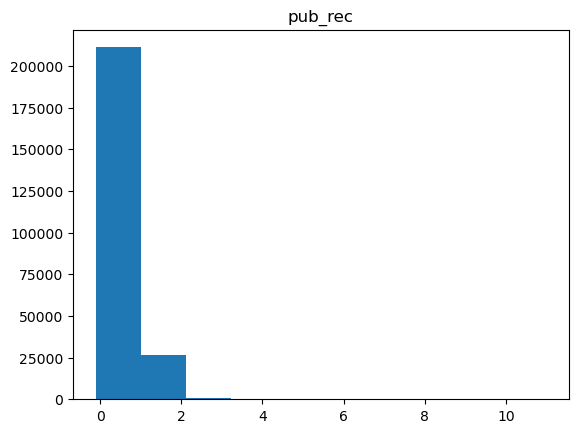

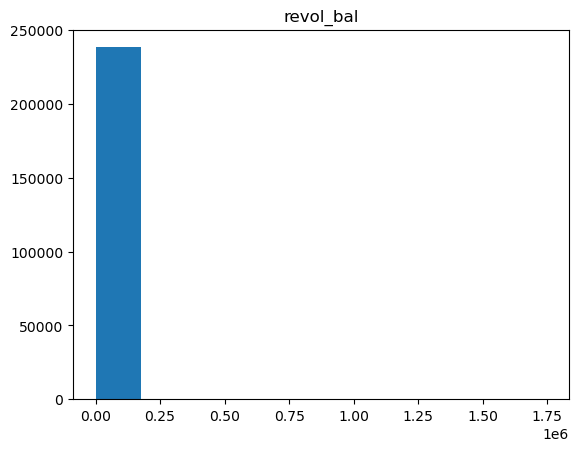

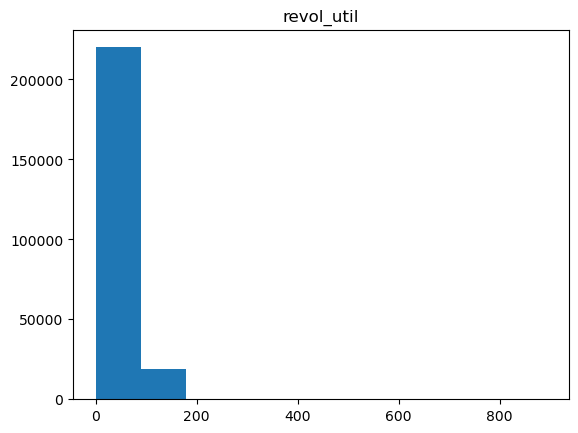

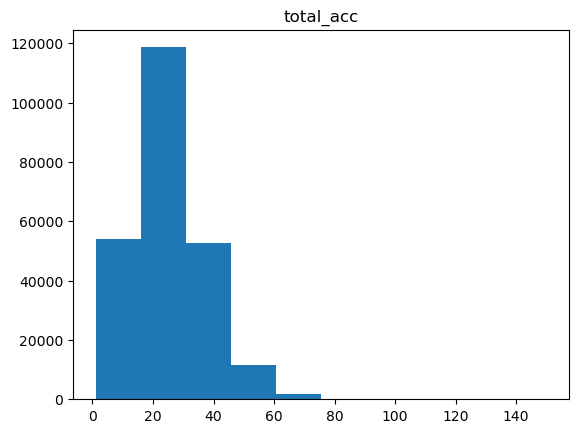

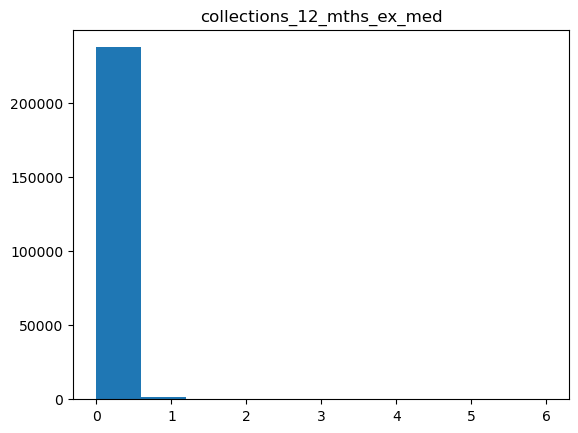

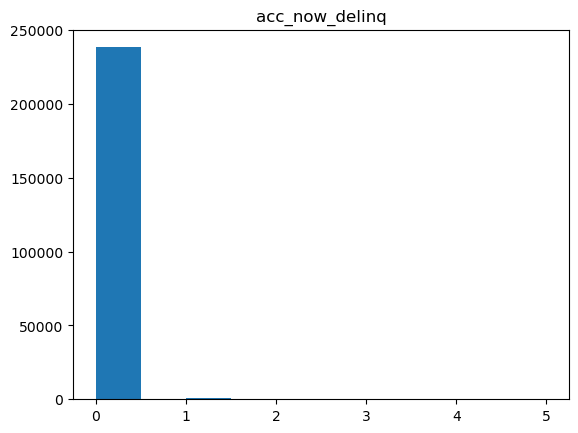

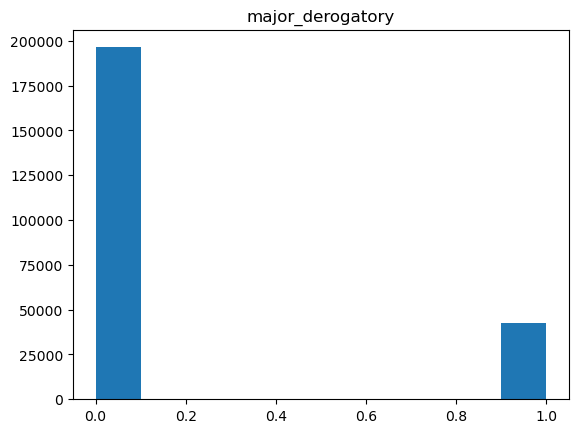

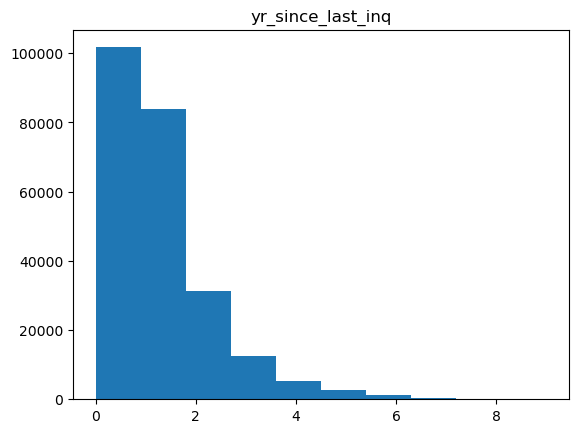

In [46]:
for column in num_loan_data.columns:
    plt.hist(num_loan_data[column])
    plt.title(column)
    plt.show()

<Axes: >

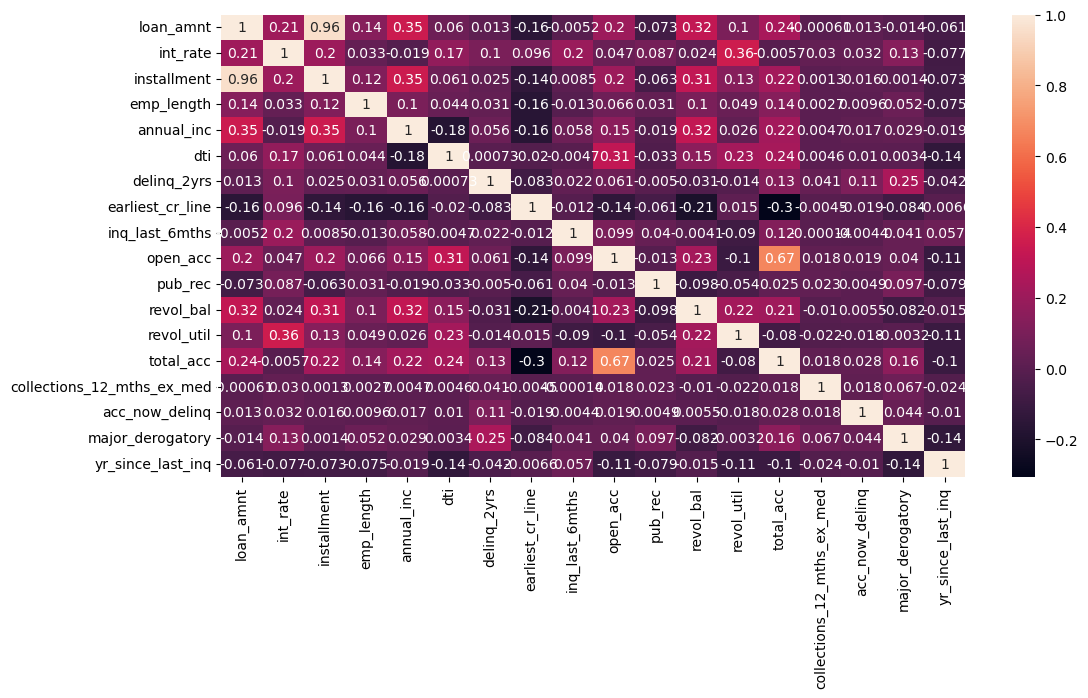

In [47]:
plt.figure(figsize=(12, 6))
sns.heatmap(data=num_loan_data.corr(), annot=True)

In [48]:
pd.pivot_table(nnc_loan_data,
               index="loan_risk_est",
               values=num_loan_data.columns)

,acc_now_delinq,annual_inc,collections_12_mths_ex_med,delinq_2yrs,dti,earliest_cr_line,emp_length,inq_last_6mths,installment,int_rate,loan_amnt,major_derogatory,open_acc,pub_rec,revol_bal,revol_util,total_acc,yr_since_last_inq
loan_risk_est,,,,,,,,,,,,,,,,,,
good,0.002592,73692.992170,0.005412,0.236330,15.918505,1997.371723,5.516471,0.872566,409.765891,13.263637,13167.962855,0.171721,10.787136,0.131097,15243.436530,53.712532,24.945764,0.982658
risky,0.003986,65615.836951,0.007822,0.291129,18.304479,1997.930169,5.438049,1.029550,442.587052,15.973031,14624.953053,0.200801,11.113025,0.148650,15150.614552,59.588562,24.333576,0.875029


**Kesimpulan:**
* Sebagian besar data numerik tidak terdistribusi secara normal
* Beberapa data memiliki outlier
* Diketahui bahwa kolom "installment" (Pembayaran bulanan yang terhutang oleh peminjam) berkorelasi dengan "loan_amnt" (Bulan lalu pembayaran diterima) sebesar 0,96 (96%), karena "installment" = "loan_amnt" * "int_rate" (Indikator pedapatan diverifikasi, tidak diferivikasi, atau sumber pendapatan diverifikasi)

Berdasarkan pivot table, kemungkinan suatu pinjaman berisiko (risky) ditunjukkan dengan indikasi berikut:
* Berdasarkan rekam jejak personal:
    - nilai "acc_now_delinq" (Jumlah akun di mana peminjam sekarang nakal) lebih tinggi
    - nilai "delinq_2yrs" (Jumlah 30+ hari insiden kenakalan dalam file kredit peminjam selama 2 tahun terakhir) lebih tinggi
    - nilai "inq_last_6months" (Jumlah pertanyaan dalam 6 bulan terakhir) lebih tinggi
    - nilai "yr_since_last_inq" (Lama tahun sejak pertanyaan terakhir) lebih rendah
<br><br>
* Berdasarkan tingkat kesulitan pembayaran:
    - nilai "annual_inc" lebih rendah
    - nilai "dti" (Rasio dihitung menggunakan total pembayaran bulanan peminjam bersama atas total kewajiban utang) lebih tinggi
    - nilai "installment" dan "loan_amnt" lebih tinggi
    - nilai "int_rate" lebih tinggi
<br><br>
* Nilai "collections_12_mths_ex_med" (Jumlah koleksi dalam 12 bulan tidak termasuk koleksi medis) lebih tinggi
* Nilai "revol_util" (Tingkat pemanfaatan jalur revolving, atau jumlah kredit peminjam menggunakan relatif terhadap semua kredit revolving yang tersedia) lebih tinggi

**Kategorikal:**

In [49]:
cat_loan_data.nunique()

term                    2
grade                   7
sub_grade              35
home_ownership          6
verification_status     3
purpose                14
addr_state             50
initial_list_status     2
loan_risk_est           2
dtype: int64

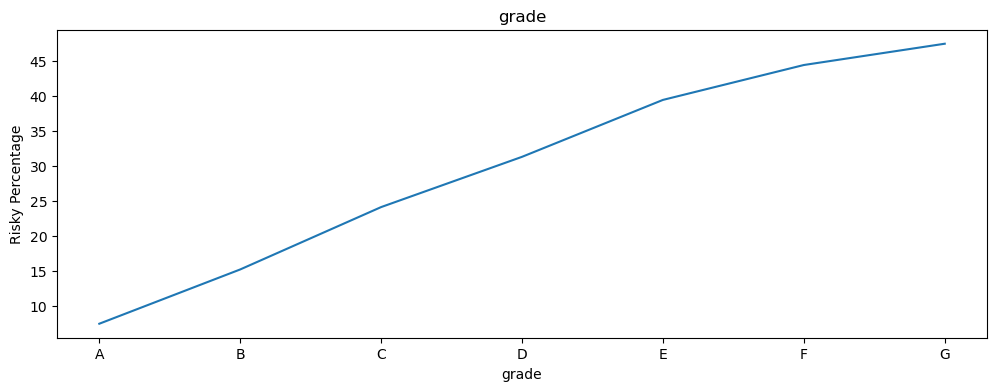

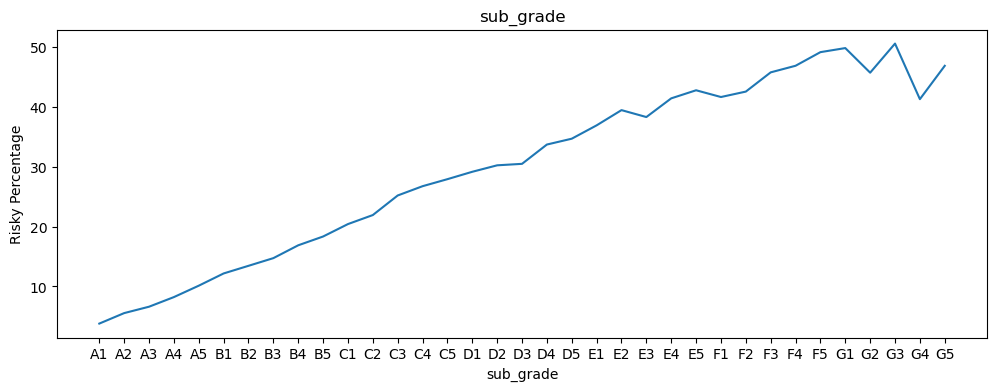

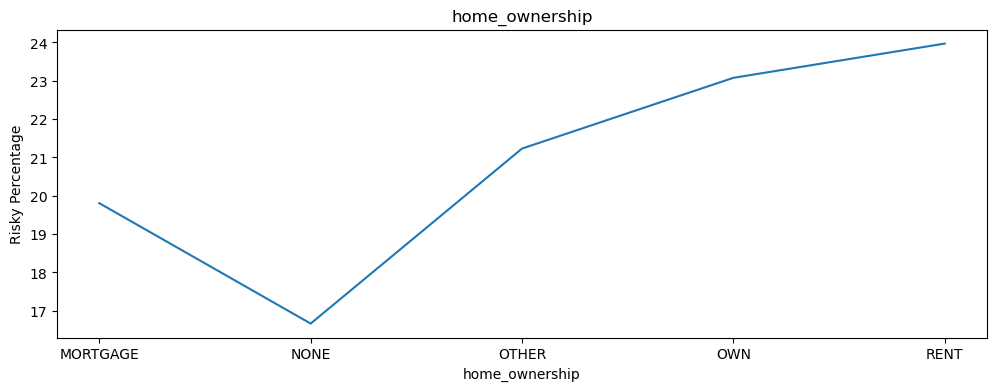

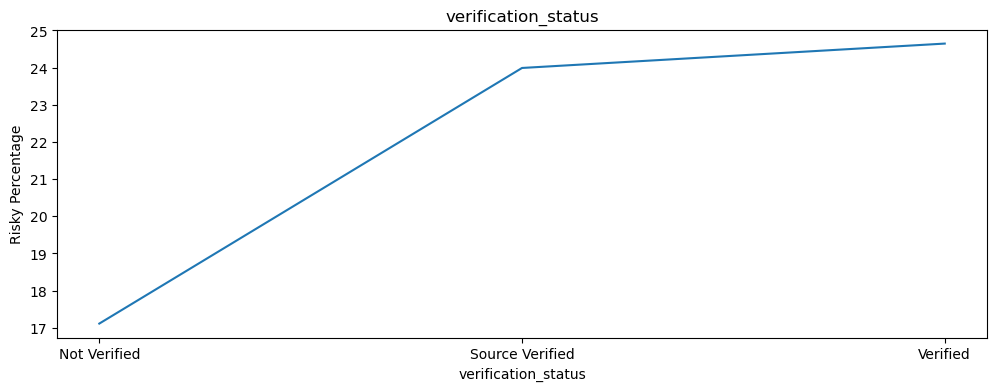

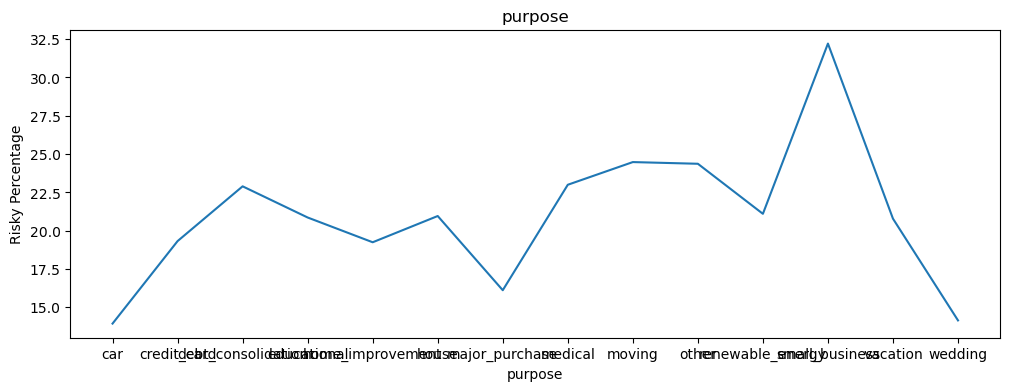

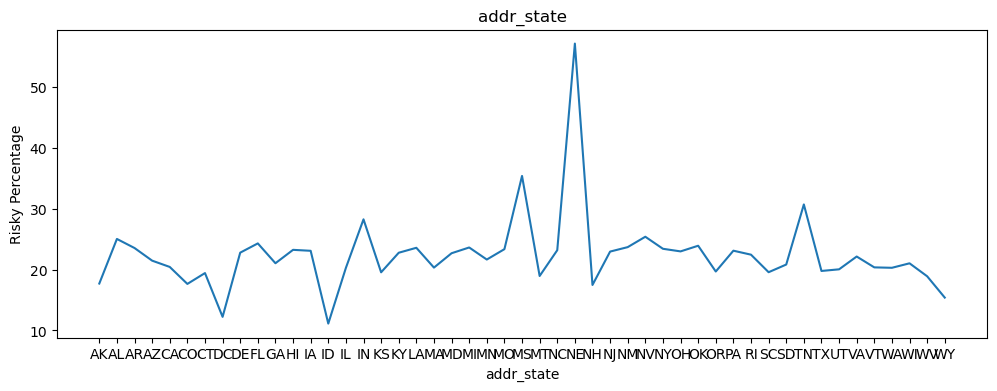

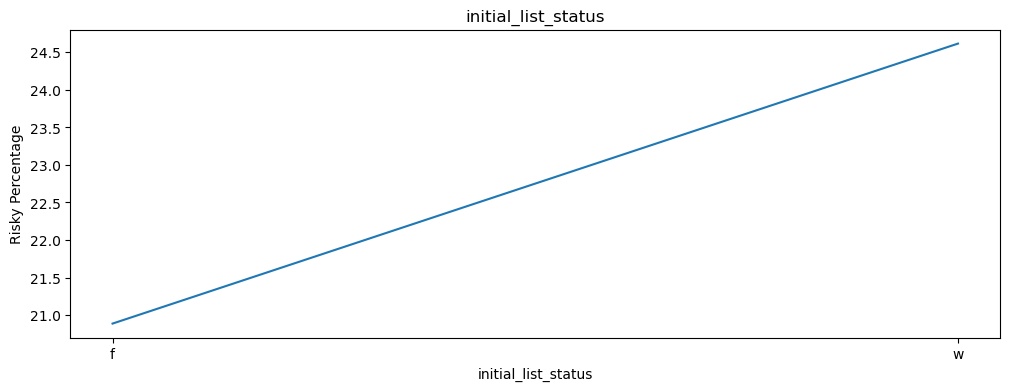

In [50]:
fields = ["grade", "sub_grade", "home_ownership",
          "verification_status", "purpose", "addr_state",
          "initial_list_status"]

for field in fields:
    plt.figure(figsize=(12, 4))
    field_risk_vis(field)

**Kesimpulan:**<br>
* Pada kolom "grade" (LC menugaskan nilai pinjaman) dan "sub_grade" (LC Ditugaskan Subgrade Pinjaman) menunjukkan bahwa semakin tinggi (ordinal) nilai pada kedua kolom, maka semakin tinggi risiko pinjaman
* Pada kolom "home_ownership" (Status kepemilikan rumah yang disediakan oleh peminjam selama pendaftaran), nilai "NONE" menunjukkan risiko rendah (good), sementara nilai "RENT" menunjukkan risiko tinggi (risky)
* Pada kolom "verification_status" (Indikator jika pendapatan bersama co-peminjam diverifikasi oleh LC, tidak diverifikasi, atau jika sumber pendapatan diverifikasi), nilai "Not Verified" mengindikasikan risiko rendah (good)
* Pada kolom "purpose" (), nilai "car" dan "wedding" menunjukkan risiko rendah (good), sementara nilai "small_business" menunjukkan risiko tinggi (risky)
* Pada kolom "initial_list_status" (), nilai "f" menunjukkan risiko rendah (good) sementara nilai "w" menunjukkan risiko tinggi (risky)

### 6. Data Transformation
Selanjutnya, dilakukan perubahan/transformasi kolom-kolom kategorikal menjadi kolom-kolom numerik untuk memudahkan pengembangan. Sebelumnya, dilakukan penghapusan kolom "sub_grade", karena kolom ini berhubungan dengan kolom "grade".

In [51]:
cat_loan_data = cat_loan_data.drop("sub_grade", axis=1)

cat_loan_data.nunique()

term                    2
grade                   7
home_ownership          6
verification_status     3
purpose                14
addr_state             50
initial_list_status     2
loan_risk_est           2
dtype: int64

* Pada kolom "terms", cukup menghilangkan kata/string " months", dan secara otomatis menjadi kolom numerik
* Pada kolom "initial_list_status", nilai diubah menjadi boolean dengan nilai "f" menjadi "0" dan "w" menjadi "1"
* Untuk kolom "grade" dan "addr_state", dilakukan ordinal encoding/pengkodean seperti pada kolom "emp_length"
* Untuk kolom "home_ownership", "verification_status", dan "purpose", dilakukan One Hot Encoding

In [52]:
# Untuk kolom "terms"
cat_loan_data["term"] = cat_loan_data["term"].str.replace(" months", "").astype("int64")

In [53]:
# Untuk kolom "initial_list_status"
cat_loan_data["initial_ls_stats_w"] = np.where(cat_loan_data["initial_list_status"] == "w", 1, 0).astype(int)
cat_loan_data = cat_loan_data.drop("initial_list_status", axis=1)
cat_loan_data["initial_list_status"] = cat_loan_data["initial_ls_stats_w"].astype("int64")
cat_loan_data = cat_loan_data.drop("initial_ls_stats_w", axis=1)

In [54]:
# Untuk kolom "grade"
grade = cat_loan_data["grade"].unique()
grade.sort()

grade_map = dict()
i = 1

for item in grade:
    grade_map[item] = i
    i = i + 1

grade_map

{'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}

In [55]:
# Untuk kolom "addr_state"
addr_state = cat_loan_data["addr_state"].unique()
addr_state.sort()

addr_st_map = dict()
i = 1

for item in addr_state:
    addr_st_map[item] = i
    i = i + 1

addr_st_map

{'AK': 1,
 'AL': 2,
 'AR': 3,
 'AZ': 4,
 'CA': 5,
 'CO': 6,
 'CT': 7,
 'DC': 8,
 'DE': 9,
 'FL': 10,
 'GA': 11,
 'HI': 12,
 'IA': 13,
 'ID': 14,
 'IL': 15,
 'IN': 16,
 'KS': 17,
 'KY': 18,
 'LA': 19,
 'MA': 20,
 'MD': 21,
 'ME': 22,
 'MI': 23,
 'MN': 24,
 'MO': 25,
 'MS': 26,
 'MT': 27,
 'NC': 28,
 'NE': 29,
 'NH': 30,
 'NJ': 31,
 'NM': 32,
 'NV': 33,
 'NY': 34,
 'OH': 35,
 'OK': 36,
 'OR': 37,
 'PA': 38,
 'RI': 39,
 'SC': 40,
 'SD': 41,
 'TN': 42,
 'TX': 43,
 'UT': 44,
 'VA': 45,
 'VT': 46,
 'WA': 47,
 'WI': 48,
 'WV': 49,
 'WY': 50}

In [56]:
cat_loan_data["grade"] = cat_loan_data["grade"].map(grade_map).astype("int64")
cat_loan_data["addr_state"] = cat_loan_data["addr_state"].map(addr_st_map).astype("int64")

cat_loan_data.head()

,term,grade,home_ownership,verification_status,purpose,addr_state,loan_risk_est,initial_list_status
0,36,2,RENT,Verified,credit_card,4,good,0
1,60,3,RENT,Source Verified,car,11,risky,0
2,36,3,RENT,Not Verified,small_business,15,good,0
3,36,3,RENT,Source Verified,other,5,good,0
5,36,1,RENT,Source Verified,wedding,4,good,0


In [57]:
# Untuk kolom "home_ownership", "verification_status", dan "purpose"
fields = ["home_ownership", "verification_status", "purpose"]

dummy_loan_data = pd.get_dummies(cat_loan_data[fields])
dummy_loan_data.head()

,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,purpose_car,...,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
0,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
5,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


### 7. Concatenation
Setelah dilakukan pemisahan, pembersihan, dan perubahan pada masing-masing kolom kategorikal dan numerik, selanjutnya adalah menggabungkan kolom-kolom tersebut menjadi satu dataset yang siap untuk dianalisis

In [58]:
final_cat_ld = cat_loan_data.drop(fields, axis=1)
final_cat_ld = pd.concat([final_cat_ld, dummy_loan_data], axis=1)
final_cat_ld.head()

,term,grade,addr_state,loan_risk_est,initial_list_status,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,...,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
0,36,2,4,good,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,60,3,11,risky,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,36,3,15,good,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,36,3,5,good,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
5,36,1,4,good,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [59]:
loan_risk_est = final_cat_ld["loan_risk_est"]
final_loan_data = pd.concat(
    [final_cat_ld.drop("loan_risk_est", axis=1), num_loan_data],
    axis=1
)

final_loan_data.head()

,term,grade,addr_state,initial_list_status,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,...,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,collections_12_mths_ex_med,acc_now_delinq,major_derogatory,yr_since_last_inq
0,36,2,4,0,0,0,0,0,0,1,...,1.0,3.0,0.0,13648,83.7,9.0,0.0,0.0,0,0.0
1,60,3,11,0,0,0,0,0,0,1,...,5.0,3.0,0.0,1687,9.4,4.0,0.0,0.0,0,3.0
2,36,3,15,0,0,0,0,0,0,1,...,2.0,2.0,0.0,2956,98.5,10.0,0.0,0.0,0,0.0
3,36,3,5,0,0,0,0,0,0,1,...,1.0,10.0,0.0,5598,21.0,37.0,0.0,0.0,0,1.0
5,36,1,4,0,0,0,0,0,0,1,...,3.0,9.0,0.0,7963,28.3,12.0,0.0,0.0,0,1.0


In [60]:
final_loan_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 238913 entries, 0 to 466283
Data columns (total 45 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   term                                 238913 non-null  int64  
 1   grade                                238913 non-null  int64  
 2   addr_state                           238913 non-null  int64  
 3   initial_list_status                  238913 non-null  int64  
 4   home_ownership_ANY                   238913 non-null  uint8  
 5   home_ownership_MORTGAGE              238913 non-null  uint8  
 6   home_ownership_NONE                  238913 non-null  uint8  
 7   home_ownership_OTHER                 238913 non-null  uint8  
 8   home_ownership_OWN                   238913 non-null  uint8  
 9   home_ownership_RENT                  238913 non-null  uint8  
 10  verification_status_Not Verified     238913 non-null  uint8  
 11  verification_

## Modelling
Setelah persiapan dan pemersihan dataset selesai, diperoleh dataset yang siap untuk dianalisis. Selanjutnya, dilakukan pengembangan model Machine Learning untuk melakukan analisis pada dataset.

### 1. Preprocessing
Berikut adalah pembagian dataset untuk pelatihan (training) dan validasi (validation). Untuk memudahkan pengembangan, nilai prediksi credit risk (kolom "loan_risk_est") yang masih kategorikal diubah menjadi numerik, nilai "good" diubah menjadi nilai 0 dan nilai "risky" menjadi nilai 1

In [61]:
from sklearn.model_selection import train_test_split

X = final_loan_data
y = np.where(loan_risk_est == "risky", 1, 0)

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=0)

### 2. Modelling and Evaluation
Selanjutnya adalah pemilihan algoritma untuk membangun model untuk analisis dataset. Algoritma yang akan digunakan dalam pemodelan analisis/klasifikasi disini adalah:

* Naive Bayes (Gaussian)
* K-Nearest Neighbors
* Decision Tree
* Random Forest

Setelah dilakukan pemodelan, selanjutnya adalah mengevaluasi model yang telah dikembangkan. Komponen evaluasi model meliputi nilai-nilai berikut:

* *Precision*: Adalah rasio banyaknya data yang teranggap sebagai anggota suatu kelas/label dari keseluruhan data yang diprediksi sebagai anggota kelas/label tersebut. Dalam hal ini, banyaknya data pinjaman yang teranggap berisiko (risky) dari kumpulan data pinjaman yang diprediksi berisiko

* *Recall*: Adalah rasio banyaknya data yang terprediksi sebagai anggota suatu kelas/label dari keseluruhan data yang sebenarnya termasuk anggota kelas/label tersebut. Dalam hal ini, banyaknya data pinjaman yang terprediksi berisiko (risky) dari kumpulan data pinjaman yang sebetulnya berisiko

In [62]:
# For Modelling
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# For Evaluation
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

Keterangan kelas/label:
* **0**: "good" (pinjaman tidak berisiko)
* **1**: "risky" (pinjaman berisiko)

In [63]:
# GAussian Naive Bayes
gnb = GaussianNB()
gnb.fit(train_X, train_y)
predict_y = gnb.predict(val_X)
print(classification_report(val_y, predict_y))

              precision    recall  f1-score   support

           0       0.82      0.87      0.84     46591
           1       0.40      0.32      0.36     13138

    accuracy                           0.75     59729
   macro avg       0.61      0.59      0.60     59729
weighted avg       0.73      0.75      0.74     59729



In [64]:
# K-Nearest Neighbors (n=5)
knn = KNeighborsClassifier()
knn.fit(train_X, train_y)
predict_y = knn.predict(val_X)
print(classification_report(val_y, predict_y))

              precision    recall  f1-score   support

           0       0.79      0.92      0.85     46591
           1       0.27      0.11      0.16     13138

    accuracy                           0.74     59729
   macro avg       0.53      0.51      0.50     59729
weighted avg       0.67      0.74      0.69     59729



In [65]:
# Decision Tree
dtree = DecisionTreeClassifier(random_state=10)
dtree.fit(train_X, train_y)
predict_y = dtree.predict(val_X)
print(classification_report(val_y, predict_y))

              precision    recall  f1-score   support

           0       0.81      0.80      0.81     46591
           1       0.33      0.34      0.33     13138

    accuracy                           0.70     59729
   macro avg       0.57      0.57      0.57     59729
weighted avg       0.71      0.70      0.70     59729



In [66]:
# Random Forest
rfc = RandomForestClassifier(random_state=10)
rfc.fit(train_X, train_y)
predict_y = rfc.predict(val_X)
print(classification_report(val_y, predict_y))

              precision    recall  f1-score   support

           0       0.80      0.98      0.88     46591
           1       0.61      0.11      0.19     13138

    accuracy                           0.79     59729
   macro avg       0.70      0.55      0.53     59729
weighted avg       0.76      0.79      0.73     59729



## Conclusion
Dari proses persiapan data, pembersihan, transformasi data, sampai tahap pemodelan dan evaluasi, diperoleh kesimpulan:

* Dataset asli memiliki beberapa kolom yang kosong/tidak ada nilai samasekali, sehingga kolom-kolom yang kosong lebih baik diabaikan/dihapus
* Sebagian kolom berisi identitas peminjam serta status akhir pinjaman. Identitas tidak berpengaruh terhadap prediksi credit risk, sedangkan status akhir pinjaman dapat langsung menunjukkan apakah pinjaman tersebut berisiko atau tidak, sehingga tidak perlu pengembangan model dan prediksi. Karena itu, kolom-kolom terkait identitas dan status akhir pinjaman diabaikan/dihapus
* Perlunya pemisahan sementara antara kolom kategorikal dengan kolom numerik, karena kedua kolom memerlukan penanganan yang berbeda
* Sebagian kolom memiliki banyak nilai kosong. Jika dipaksakan untuk menggunakan semuanya, maka harus menghilangkan lebih dari 50% baris data. Adapun bila nilai kosongnya sedikit, maka masih bisa diatasi dengan imputasi data
* Terkadang beberapa kolom memiliki format yang salah, misal kolom kategorikal yang seharusnya numerik karena menunjukkan jangka waktu
* Setelah pembersihan kedua jenis data, perlu dilakukan transformasi pada data kategorikal menjadi numerik untuk memudahkan pengembangan model
* Setelah semua data ditransformasi dan digabungkan menjadi satu dataset siap pakai, dilanjutkan ke tahap preprocessing
* Preprocessing data meliputi pemisahan data dengan kelas/label, dalam hal ini adalah perkiraan credit risk berisiko atau tidak, kemudian dilakukan pemisahan antara data latih (training) dan data uji/validasi (test/validation)
* Selanjutnya, dilakukan pemodelan untuk pelatihan data latih dan prediksi data uji, menggunakan algoritma/model yang tepat sesuai kebutuhan
* Evaluasi model dilakukan untuk meninjau apakah model sudah mampu memprediksi data dengan baik atau belum

In [67]:
"""Sekian dan Terimakasih"""

'Sekian dan Terimakasih'